In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
import osmnx as ox

import pysal
# from libpysal import esda
from libpysal import weights
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

ox.config(use_cache=True, log_console=True)
default_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]


/Users/lamderek/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Generate Squares

In [2]:
# set the filepath and load
fp = "/Users/lamderek/Documents/Sudo/Study/University Study/Year 4/RECO4001 Dissertation/02_Quantative Analysis/01_resources/HK_esri_shp/HKDistrict18.shp"
hongkong = gpd.read_file(fp)
hongkong = hongkong.to_crs("EPSG:2326")

# hongkong = hongkong.dissolve()
# hongkong.plot(figsize = (5,5), color= default_color, edgecolor="white")

hongkong2fp = "/Users/lamderek/Documents/Sudo/Study/University Study/Year 4/RECO4001 Dissertation/02_Quantative Analysis/01_resources/HK_princeton_shp/HKG_adm0.shp"
hongkong2 = gpd.read_file(hongkong2fp)
hongkong2 = hongkong2.to_crs("EPSG:2326")
# hongkong2.plot(figsize = (10,10), color= default_color, edgecolor="white")

In [3]:
# dx, dy: (1000, 2m 28.7s) (2000, 51.7s) (3000, 15.4s)
dx = 2000
dy = 2000
xmin, ymin, xmax, ymax = hongkong2.geometry[0].bounds
xs = np.arange(np.floor(xmin), np.ceil(xmax) + 1, dx) 
ys = np.arange(np.floor(ymin), np.ceil(ymax) + 1, dy)
rectangles = (Polygon([(x_start, y_start), (x_end, y_start), 
                       (x_end, y_end), (x_start, y_end)])
              for x_start, x_end in zip(xs, xs[1:])
              for y_start, y_end in zip(ys, ys[1:]))
rectangles = [rectangle for rectangle in rectangles 
              if hongkong2.geometry[0].contains(rectangle) or hongkong2.geometry[0].intersects(rectangle)]

grid = gpd.GeoDataFrame(geometry=gpd.GeoSeries(rectangles))
grid_xmin, grid_ymin, grid_xmax, grid_ymax = grid.total_bounds
grid["DCODE"] = [chr(int((entry.geometry.bounds[1] - grid_ymin)/dy + 65)) + str(int((entry.geometry.bounds[0]-grid_xmin)/dx)) for index, entry in grid.iterrows()]
grid = grid[["DCODE", "geometry"]]
grid.sample(3)

,DCODE,geometry
347,H22,"POLYGON ((844976.000 815661.000, 846976.000 81..."
262,E18,"POLYGON ((836976.000 809661.000, 838976.000 80..."
169,K13,"POLYGON ((826976.000 821661.000, 828976.000 82..."


<AxesSubplot:>

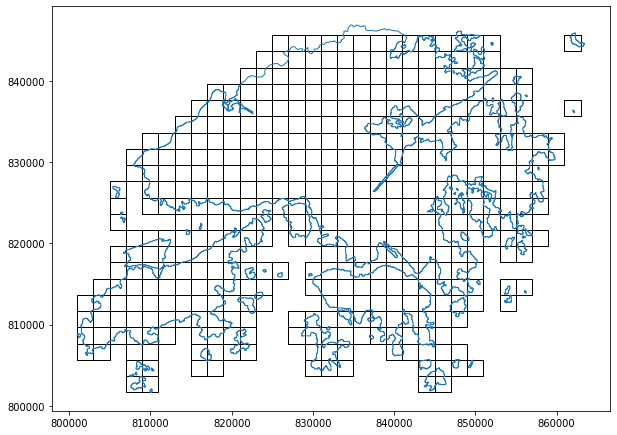

In [4]:
ax = grid.plot(facecolor= "none", edgecolor='black', figsize = (10,10))
hongkong2.plot(facecolor= "none", edgecolor = default_color, ax = ax)

### Variables Engineering

##### EV Chargers – Dependent Variable

In [74]:
ev_fp = "/Users/lamderek/Documents/Sudo/Study/University Study/Year 4/RECO4001 Dissertation/02_Quantative Analysis/01_resources/ev_chargers_organised.xlsx"
ev_df = pd.read_excel(ev_fp)
ev_chargers = gpd.GeoDataFrame(ev_df, geometry=gpd.points_from_xy(ev_df.Easting, ev_df.Northing))

ev_chargers = ev_chargers.set_crs("EPSG:2326")

<AxesSubplot:>

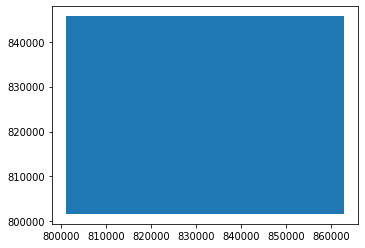

In [77]:
trial.plot()

<AxesSubplot:>

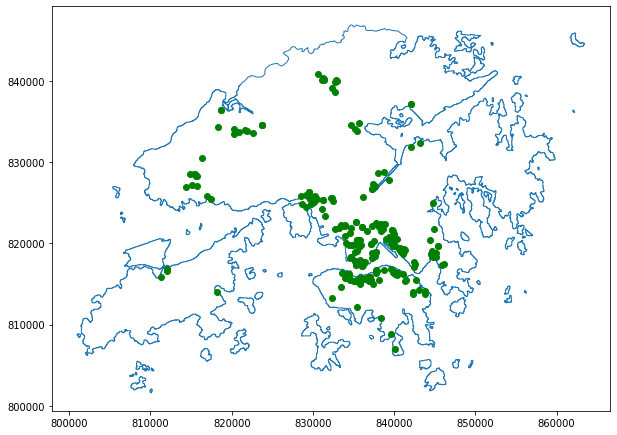

In [11]:
ax = hongkong2.plot(color= "white", edgecolor = default_color, figsize = (10,10))
ev_chargers.plot(ax = ax, c = "g")

In [76]:
ev_sjoined = gpd.sjoin(ev_chargers, trial, predicate="within",how = "left")
# ev_sjoined.sample(5)

ev_grouped = ev_sjoined.groupby("DCODE").size()
ev_tempdf = ev_grouped.to_frame().reset_index()
ev_tempdf.columns = ['DCODE', 'EV_COUNT']

final_output = trial.merge(ev_tempdf, on='DCODE', how='outer')
final_output.sample(5)

<ipython-input-76-9f5ff81581c0>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2326
Right CRS: None

  ev_sjoined = gpd.sjoin(ev_chargers, trial, predicate="within",how = "left")


,DCODE,geometry,EV_COUNT
612,S27,"POLYGON ((854976.000 837661.000, 856976.000 83...",NaN
352,A16,"POLYGON ((832976.000 801661.000, 834976.000 80...",NaN
478,Q21,"POLYGON ((842976.000 833661.000, 844976.000 83...",NaN
18,S0,"POLYGON ((800976.000 837661.000, 802976.000 83...",NaN
366,O16,"POLYGON ((832976.000 829661.000, 834976.000 82...",NaN


In [73]:
ev_sjoined = gpd.sjoin(ev_chargers, trial, predicate="within",how = "left")
# ev_sjoined.sample(5)

ev_grouped = ev_sjoined.groupby("DCODE").size()
ev_tempdf = ev_grouped.to_frame().reset_index()
ev_tempdf.columns = ['DCODE', 'EV_COUNT']

final_output = trial.merge(ev_tempdf, on='DCODE', how='outer')
final_output.sample(5)

<ipython-input-73-9f5ff81581c0>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2326
Right CRS: None

  ev_sjoined = gpd.sjoin(ev_chargers, trial, predicate="within",how = "left")


,DCODE,geometry,EV_COUNT
432,O19,"POLYGON ((838976.000 829661.000, 840976.000 82...",NaN
142,K6,"POLYGON ((812976.000 821661.000, 814976.000 82...",NaN
155,B7,"POLYGON ((814976.000 803661.000, 816976.000 80...",NaN
585,N26,"POLYGON ((852976.000 827661.000, 854976.000 82...",NaN
499,P22,"POLYGON ((844976.000 831661.000, 846976.000 83...",NaN


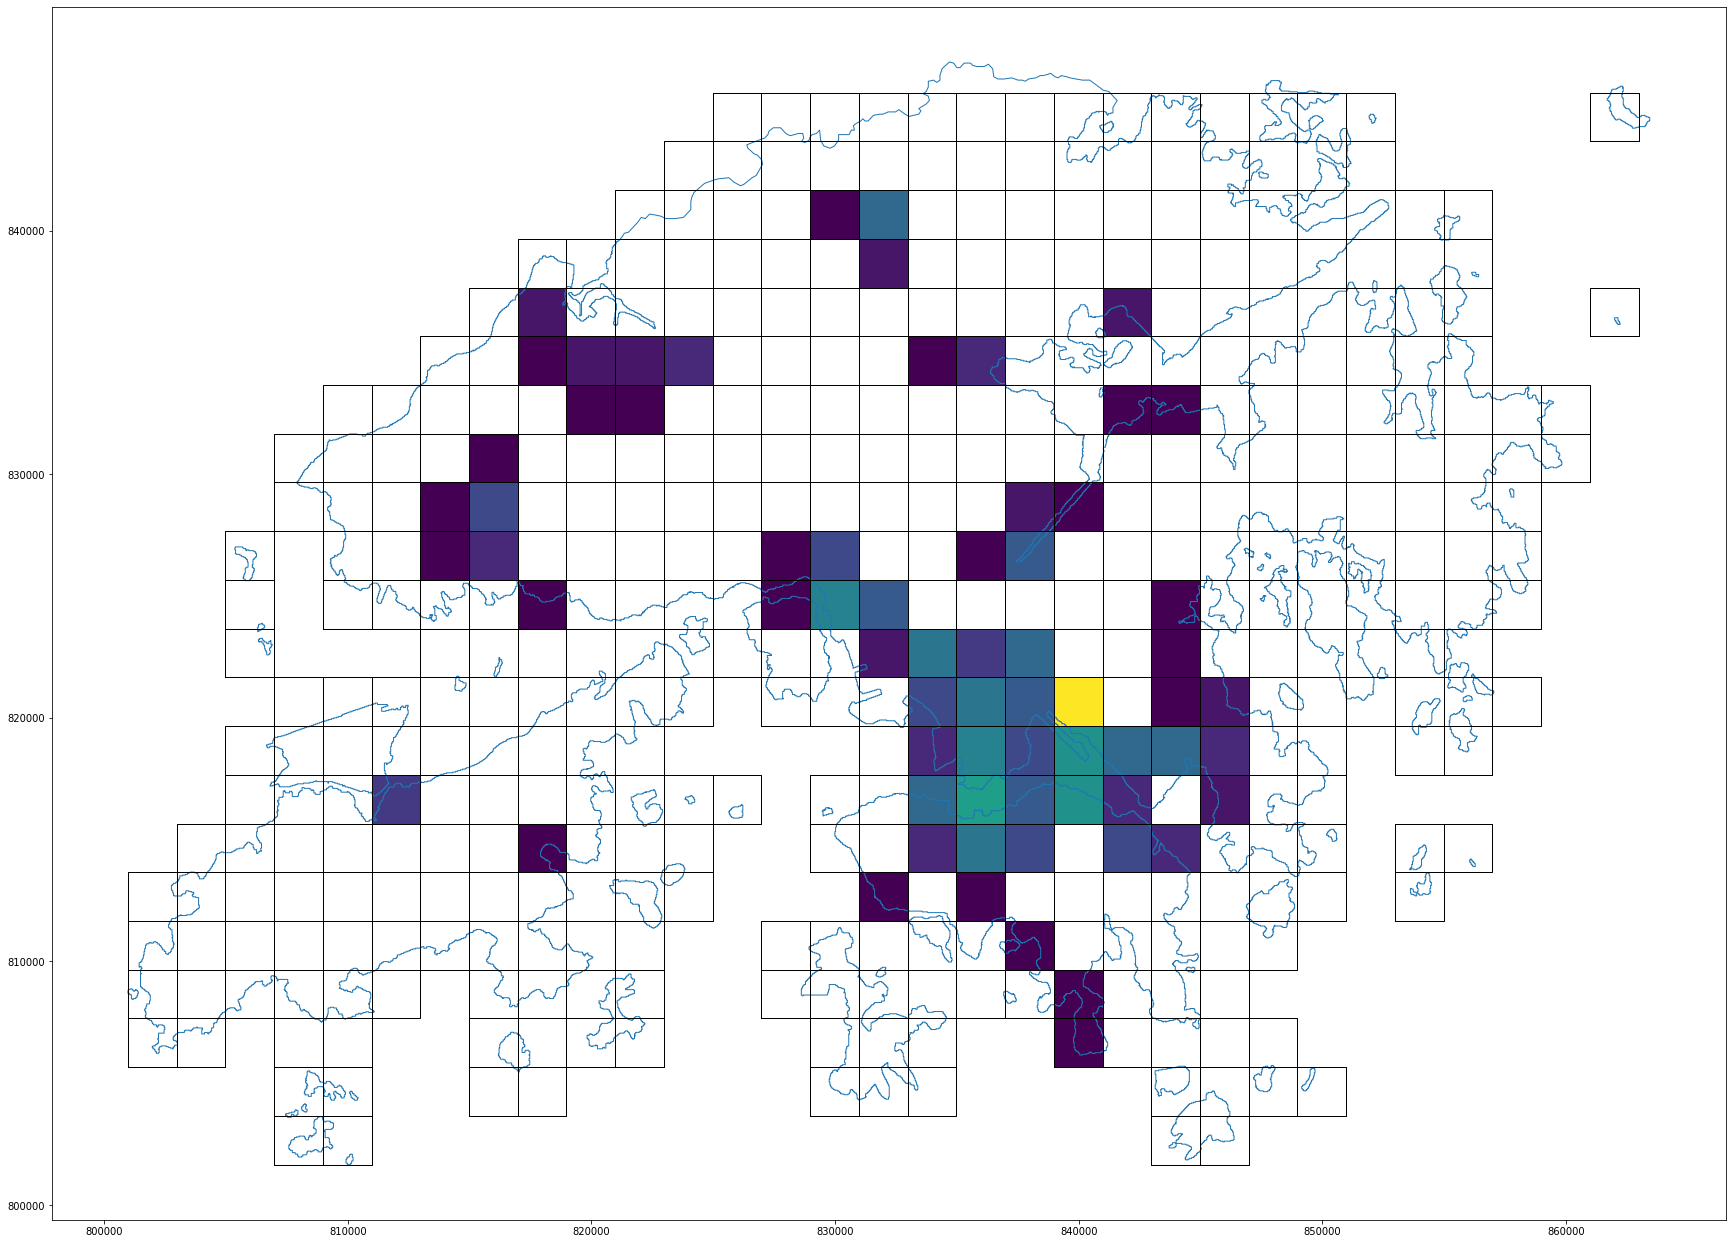

In [35]:
ax = final_output.plot(column = "EV_COUNT", figsize = (30,30))
hongkong2.plot(ax = ax, facecolor = "none", edgecolor = default_color)
grid.plot(ax = ax, facecolor = "none")

# ax = final_output.plot(column = "EV_COUNT", legend = True, figsize = (20,20), legend_kwds = {'shrink':0.6} )
# ax.axis('off')

# plt.savefig("testing.png")

<AxesSubplot:>

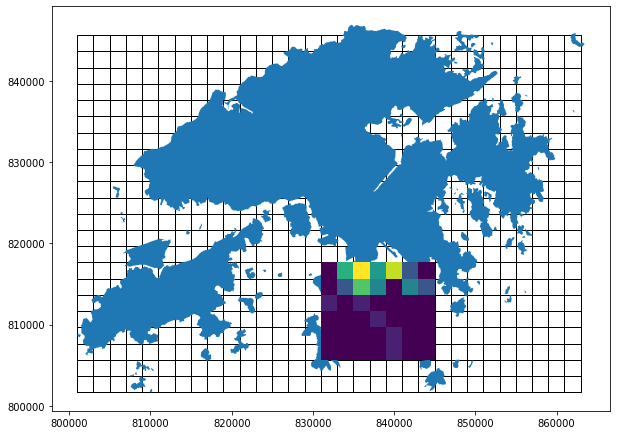

In [122]:
ax = final_output.plot(facecolor = "none", figsize = (10,10))
hongkong2.plot(ax = ax)
hki.plot(column = "EV_COUNT", ax = ax)

In [121]:
hki = final_output[(final_output.geometry.bounds.minx > 830000) & (final_output.geometry.bounds.maxx < 845000) & (final_output.geometry.bounds.miny > 805000) & (final_output.geometry.bounds.maxy < 819000)]
# final_output.sample(5).geometry.bounds

In [89]:
final_output.EV_COUNT = final_output.EV_COUNT.fillna(0)

In [95]:
final_output.sample(5)

,DCODE,geometry,EV_COUNT,w_count
106,S4,"POLYGON ((808976.000 837661.000, 810976.000 83...",0.0,0.000
602,I27,"POLYGON ((854976.000 817661.000, 856976.000 81...",0.0,0.000
148,Q6,"POLYGON ((812976.000 833661.000, 814976.000 83...",0.0,0.800
48,E2,"POLYGON ((804976.000 809661.000, 806976.000 80...",0.0,0.000
338,I15,"POLYGON ((830976.000 817661.000, 832976.000 81...",0.0,0.125


In [132]:
import geoplot

ax = geoplot.kdeplot(ev_chargers, clip = hongkong2.geometry, shade = True, cmap ='Reds')

geoplot.polyplot(hongkong2, ax = ax, zorder = 1)

ModuleNotFoundError: No module named 'geoplot'

In [127]:
w = weights.Queen.from_dataframe(final_output, idVariable = "DCODE")
w.transform = "R"
# final_output.sample(1)

In [128]:
final_output["w_count"] = weights.lag_spatial(w, final_output["EV_COUNT"])

In [129]:
y = final_output["EV_COUNT"]
moran = Moran(y, w)
moran.I

0.14343264735189878

In [130]:
moran.p_sim

0.001

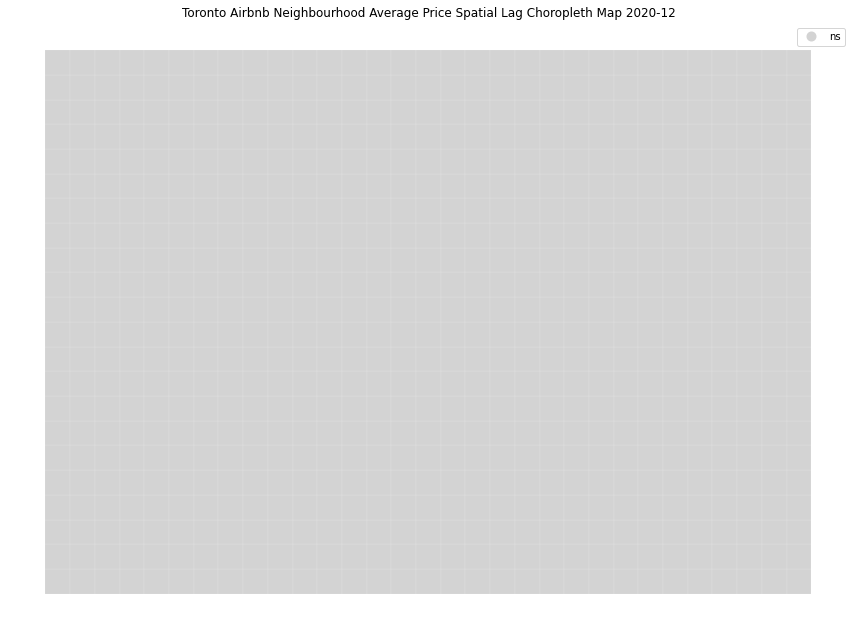

In [131]:
m_local = Moran_Local(y, w)

fig, ax = plt.subplots(figsize=(12,10)) 
lisa_cluster(m_local, final_output, p=moran.p_sim, ax=ax) 

# nbr_final.boundary.plot(ax=ax) 


plt.title('Toronto Airbnb Neighbourhood Average Price Spatial Lag Choropleth Map 2020-12') 
plt.tight_layout() 
plt.show()

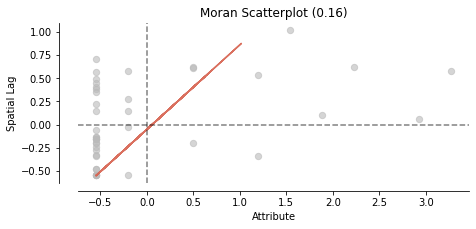

In [126]:
fig, ax = moran_scatterplot(moran, aspect_equal = True)
plt.show()

##### Variable – Metered Parking Spaces

In [11]:
mps_fp = "/Users/lamderek/Documents/Sudo/Study/University Study/Year 4/RECO4001 Dissertation/02_Analysis/02_original data/02_variables/C_parkingspaces.csv"
mps_df = pd.read_csv(mps_fp, usecols = ['PoleId','Latitude','Longitude'])

mps = gpd.GeoDataFrame(mps_df, geometry=gpd.points_from_xy(mps_df.Longitude, mps_df.Latitude))
mps = mps.drop(columns=['Latitude', 'Longitude'])
mps = mps.set_crs("EPSG:4326")
mps = mps.to_crs("EPSG:2326")

# mps = gpd.clip(mps, grid, keep_geom_type=False)
mps.sample(5)

,PoleId,geometry
8445,2630,POINT (841839.037 815944.990)
18056,9447,POINT (835130.799 820916.806)
17280,8594,POINT (837722.493 820347.548)
14801,6238,POINT (835577.021 820364.507)
15662,6952,POINT (837612.611 821224.724)


In [12]:
mps_sjoined = gpd.sjoin(mps, grid, predicate="within", how = "left")
mps_grouped = mps_sjoined.groupby("DCODE").size()
mps_tempdf = mps_grouped.to_frame().reset_index()
mps_tempdf.columns = ['DCODE', 'MPS_COUNT']

final_output = final_output.merge(mps_tempdf, on='DCODE', how='outer')
final_output.sample(10)

<ipython-input-12-e07c9bf4b2b1>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2326
Right CRS: None

  mps_sjoined = gpd.sjoin(mps, grid, predicate="within", how = "left")


,DCODE,geometry,EV_COUNT,MPS_COUNT
328,I21,"POLYGON ((842976.000 817661.000, 844976.000 81...",7.0,NaN
320,A21,"POLYGON ((842976.000 801661.000, 844976.000 80...",NaN,NaN
97,N8,"POLYGON ((816976.000 827661.000, 818976.000 82...",NaN,NaN
8,G1,"POLYGON ((802976.000 813661.000, 804976.000 81...",NaN,NaN
266,I18,"POLYGON ((836976.000 817661.000, 838976.000 81...",5.0,420.0
12,G2,"POLYGON ((804976.000 813661.000, 806976.000 81...",NaN,NaN
146,O11,"POLYGON ((822976.000 829661.000, 824976.000 82...",NaN,NaN
251,M17,"POLYGON ((834976.000 825661.000, 836976.000 82...",1.0,440.0
263,F18,"POLYGON ((836976.000 811661.000, 838976.000 81...",NaN,53.0
182,C14,"POLYGON ((828976.000 805661.000, 830976.000 80...",NaN,NaN


<AxesSubplot:>

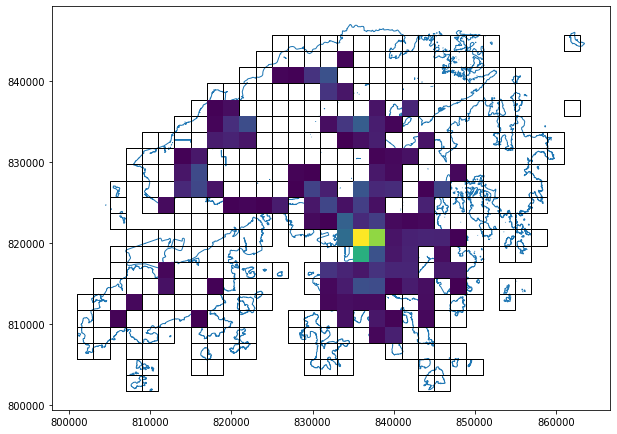

In [13]:
# Plotting Scatter
ax = hongkong.plot(figsize = (10,10), facecolor= "none", edgecolor=default_color)
grid.plot(facecolor= "none", edgecolor="black", ax = ax)
final_output.plot(column = "MPS_COUNT", ax = ax)

##### Variables - Building Density

In [14]:
hki_buildings = ox.geometries.geometries_from_place("Hong Kong, China", {"building": True}, which_result=None, buffer_dist=None)
kw_buildings = ox.geometries.geometries_from_place("Kowloon", {"building": True}, which_result=None, buffer_dist=None)
nt_buildings = ox.geometries.geometries_from_place("New Territories", {"building": True}, which_result=None, buffer_dist=None)

/Users/lamderek/anaconda3/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/Users/lamderek/anaconda3/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/lamderek/anaconda3/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/lamderek/anaconda3/lib/py

In [15]:
bdg_lst = [hki_buildings,kw_buildings,nt_buildings]
hk_buildings = gpd.GeoDataFrame(pd.concat(bdg_lst, ignore_index=True))

hk_buildings = hk_buildings[["geometry"]]
hk_buildings.sample(10)

hk_buildings = hk_buildings.set_crs("EPSG:4326")
hk_buildings = hk_buildings.to_crs("EPSG:2326")

/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

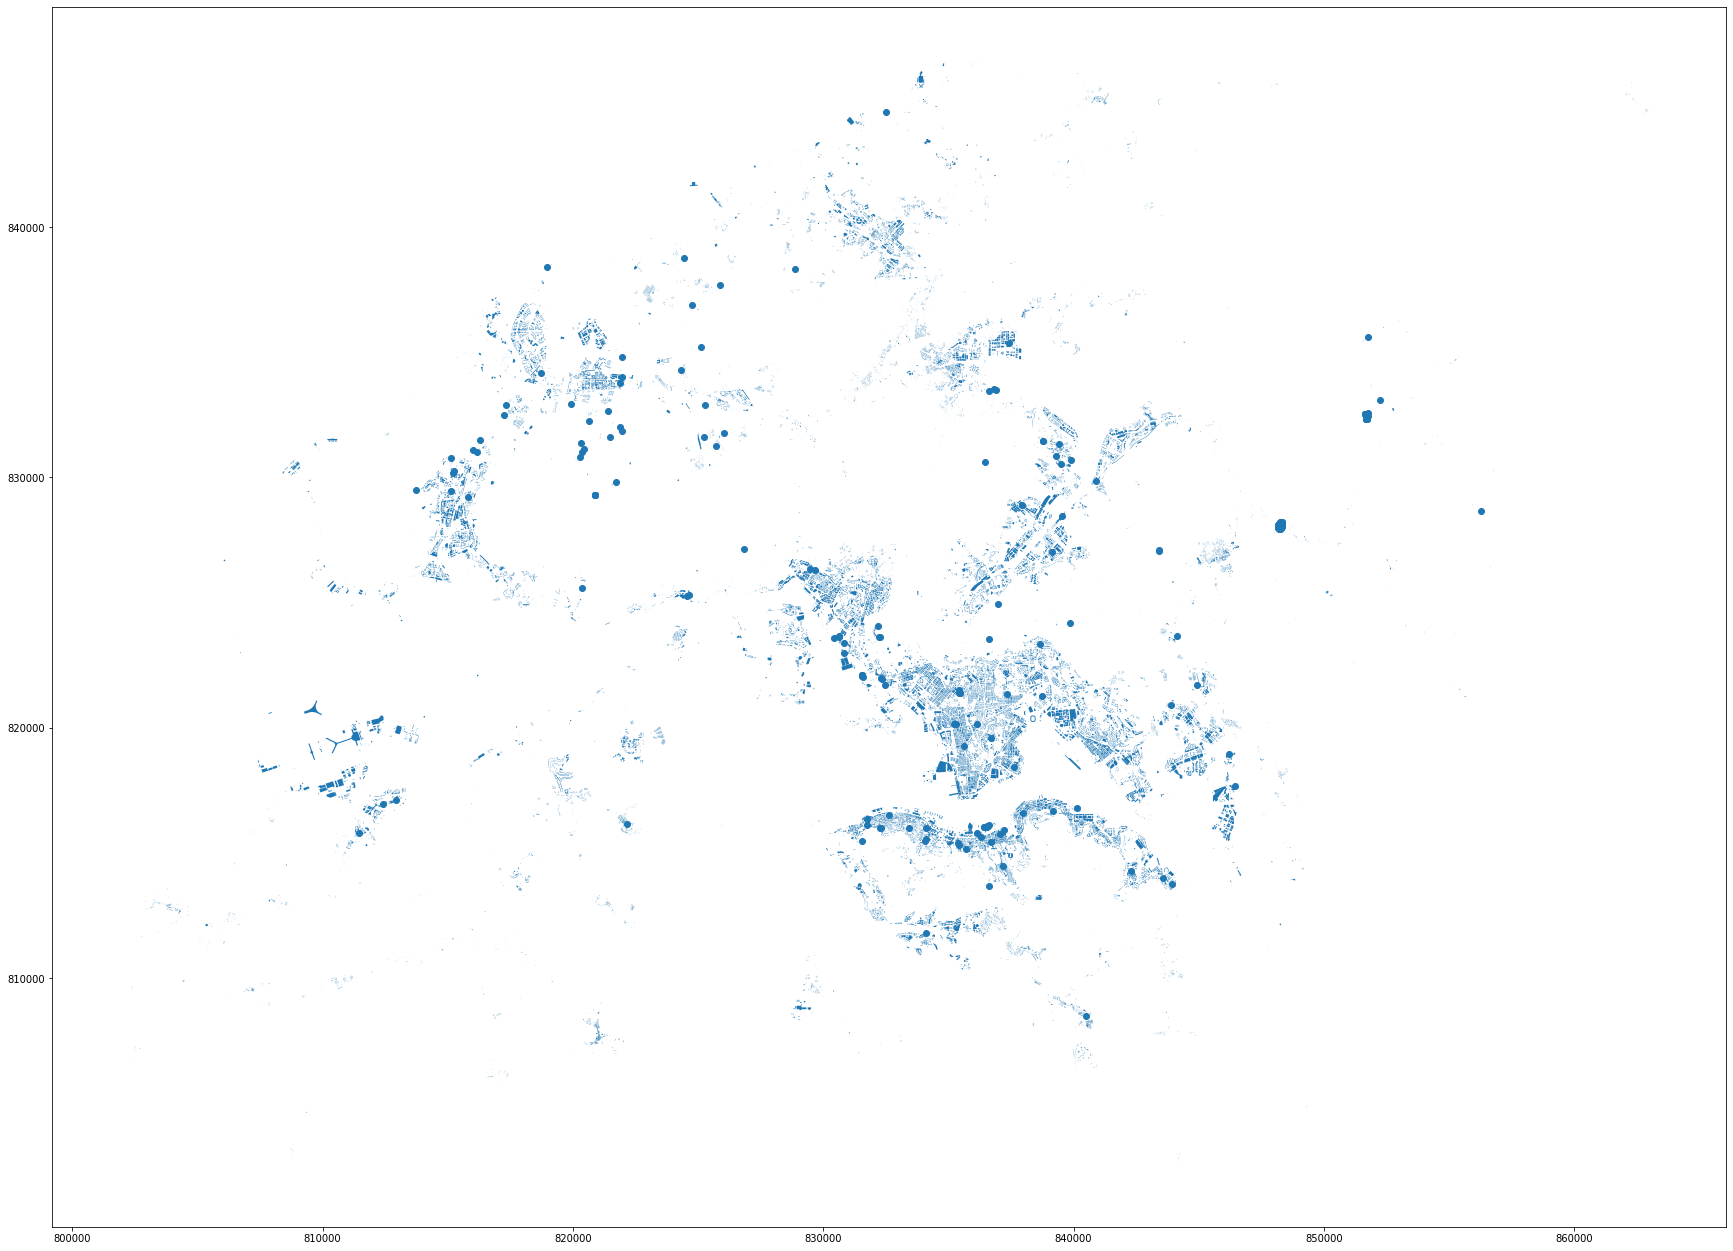

In [16]:
hk_buildings.plot(figsize = (30,30))

In [17]:
bldg_sjoined = gpd.sjoin(hk_buildings, grid, predicate="within", how = "left")
bldg_grouped = bldg_sjoined.groupby("DCODE").size()
bldg_tempdf = bldg_grouped.to_frame().reset_index()
bldg_tempdf.columns = ['DCODE', 'BLDG_COUNT']

final_output = final_output.merge(bldg_tempdf, on='DCODE', how='outer')

/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-17-c18dd1b0e7a9>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2326
Right CRS: None

  bldg_sjoined = gpd.sjoin(hk_buildings, grid, predicate="within", how = "left")


In [18]:
# DataFrame.corr(method='pearson', min_periods=1)

final_output.corr(method='spearman')

/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,EV_COUNT,MPS_COUNT,BLDG_COUNT
EV_COUNT,1.000000,0.420336,0.511104
MPS_COUNT,0.420336,1.000000,0.728026
BLDG_COUNT,0.511104,0.728026,1.000000


##### Variables - Population Census

In [6]:
file_census ="/Users/lamderek/Documents/Sudo/Study/University Study/Year 4/RECO4001 Dissertation/02_Quantative Analysis/02_original data/02_variables/A_HKGS_Dataset_2016-Population-By-census-Statistics-By-Large-Street-Block-Group_2019-12-05-0800-00_fullset.gml"

census = gpd.read_file(file_census)

css_columns = ['FID', 'LSBG_ENG', 'T_POP', 'T_WP', 'EDU_PSEC', 'MA_HH', 'geometry']
census = census.filter(css_columns)
census['EDU_PERCENT'] = census["EDU_PSEC"] / census["T_POP"]



(1622, 8)

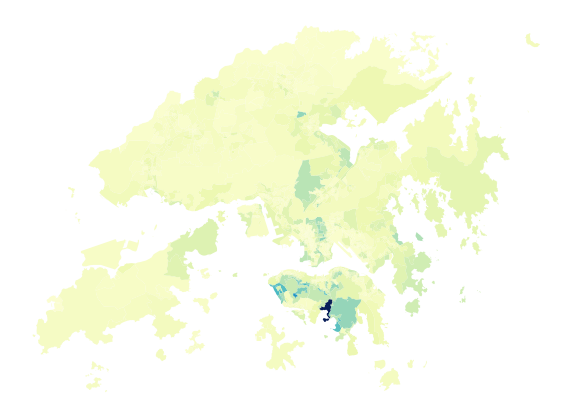

In [13]:
census.plot(column = "MA_HH", figsize = (10,10),cmap = "YlGnBu")
plt.axis('off')

plt.savefig("richbefore.png")

In [14]:
css_sjoined = census.sjoin_nearest(grid, how="left")

css_mean = css_sjoined.groupby("DCODE",as_index=False).mean()
css_sum = css_sjoined.groupby("DCODE",as_index=False).sum()


/Users/lamderek/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:2050: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2326
Right CRS: None

  return geopandas.sjoin_nearest(


In [16]:
css_mean = css_mean[["DCODE", "MA_HH", "EDU_PERCENT"]]
css_sum = css_sum[["DCODE", "T_POP", "T_WP"]]

temp_trial = grid.merge(css_mean, on='DCODE', how='outer')
temp_trial = temp_trial.merge(css_sum, on='DCODE', how='outer')

temp_trial.sample(5)

# final_output = final_output.merge(bldg_tempdf, on='DCODE', how='outer')

,DCODE,geometry,MA_HH,EDU_PERCENT,T_POP,T_WP
162,S12,"POLYGON ((824976.000 837661.000, 826976.000 83...",19900.0,0.226513,8726.0,3918.0
355,P22,"POLYGON ((844976.000 831661.000, 846976.000 83...",34150.0,0.302061,5429.0,2773.0
443,O28,"POLYGON ((856976.000 829661.000, 858976.000 82...",51780.0,0.220708,1468.0,335.0
232,M16,"POLYGON ((832976.000 825661.000, 834976.000 82...",40030.0,0.269571,23112.0,11354.0
30,A4,"POLYGON ((808976.000 801661.000, 810976.000 80...",22750.0,0.269458,1696.0,600.0


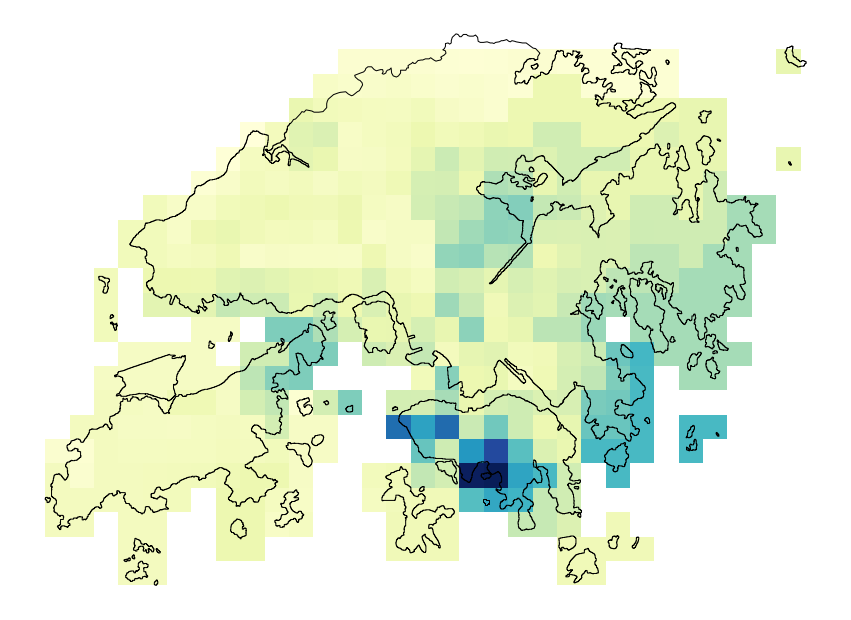

In [27]:

ax = temp_trial.plot(column = "MA_HH", figsize = (15,15), cmap = 'YlGnBu')
hongkong2.plot(facecolor = "none",ax = ax)

plt.axis("off")


plt.savefig("richafter.png")

### Analysis!

In [22]:
temp_trial.corr(method='pearson')

/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,EV_COUNT,MPS_COUNT,BLDG_COUNT,MA_HH,EDU_PERCENT,T_POP,T_WP
EV_COUNT,1.000000,0.296282,0.392141,-0.239392,-0.071648,0.557093,0.564045
MPS_COUNT,0.296282,1.000000,0.788432,-0.141674,-0.092082,0.494431,0.503424
BLDG_COUNT,0.392141,0.788432,1.000000,0.032837,0.103545,0.672394,0.680965
MA_HH,-0.239392,-0.141674,0.032837,1.000000,0.591010,-0.019733,-0.005845
EDU_PERCENT,-0.071648,-0.092082,0.103545,0.591010,1.000000,0.054658,0.075625
T_POP,0.557093,0.494431,0.672394,-0.019733,0.054658,1.000000,0.998667
T_WP,0.564045,0.503424,0.680965,-0.005845,0.075625,0.998667,1.000000


In [23]:
temp_trial.corr(method='spearman')

/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,EV_COUNT,MPS_COUNT,BLDG_COUNT,MA_HH,EDU_PERCENT,T_POP,T_WP
EV_COUNT,1.000000,0.420336,0.511104,-0.214173,-0.080863,0.569441,0.582635
MPS_COUNT,0.420336,1.000000,0.728026,-0.085089,-0.114770,0.579774,0.585189
BLDG_COUNT,0.511104,0.728026,1.000000,0.131703,0.197959,0.732252,0.730130
MA_HH,-0.214173,-0.085089,0.131703,1.000000,0.588727,0.109307,0.156854
EDU_PERCENT,-0.080863,-0.114770,0.197959,0.588727,1.000000,0.190169,0.267267
T_POP,0.569441,0.579774,0.732252,0.109307,0.190169,1.000000,0.989829
T_WP,0.582635,0.585189,0.730130,0.156854,0.267267,0.989829,1.000000


### Figure Making

/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


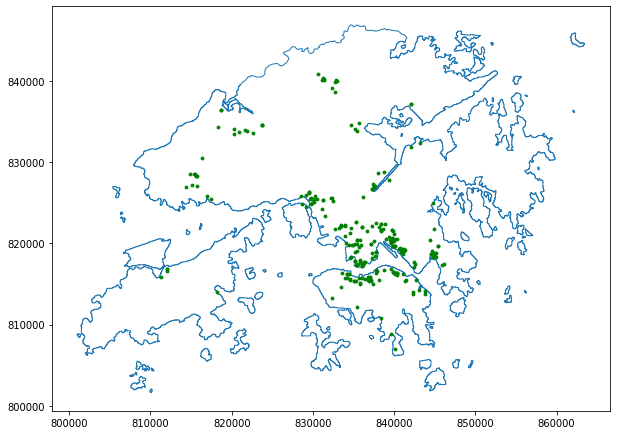

In [29]:
ax = hongkong2.plot(color= "white", edgecolor = default_color, figsize = (10,10))
ev_chargers.plot(ax = ax, c = "g", markersize = 8)

# plt.savefig("/Users/lamderek/Documents/Sudo/Study/University Study/Year 4/RECO4001 Dissertation/02_Analysis/01_resources/output_figures/ev_scatter")

/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


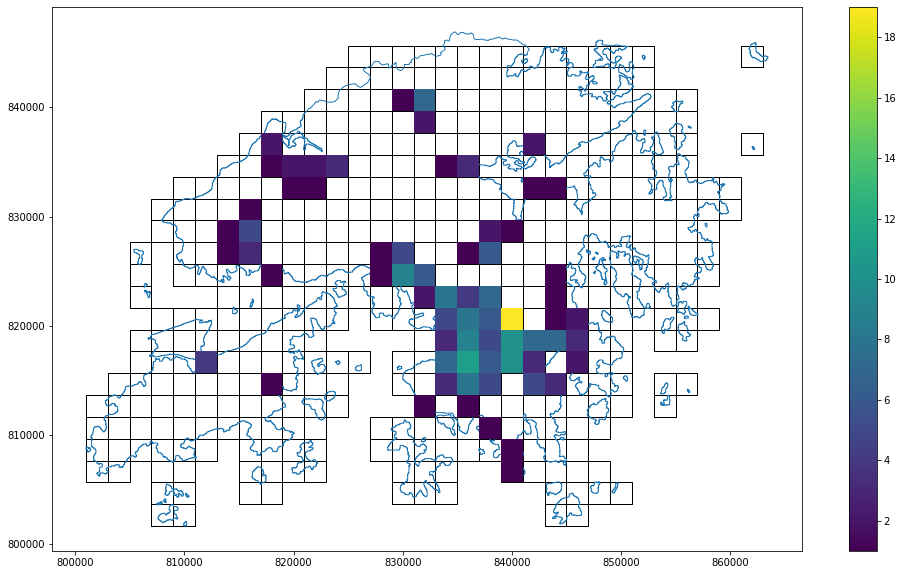

In [35]:
ax = grid.plot(color= "white", edgecolor='black', figsize = (17,10))
hongkong2.plot(facecolor="none", edgecolor = default_color, ax = ax)
final_output.plot(column = "EV_COUNT", ax = ax, legend = True)

# plt.savefig("/Users/lamderek/Documents/Sudo/Study/University Study/Year 4/RECO4001 Dissertation/02_Analysis/01_resources/output_figures/ev_chloropeth")


/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


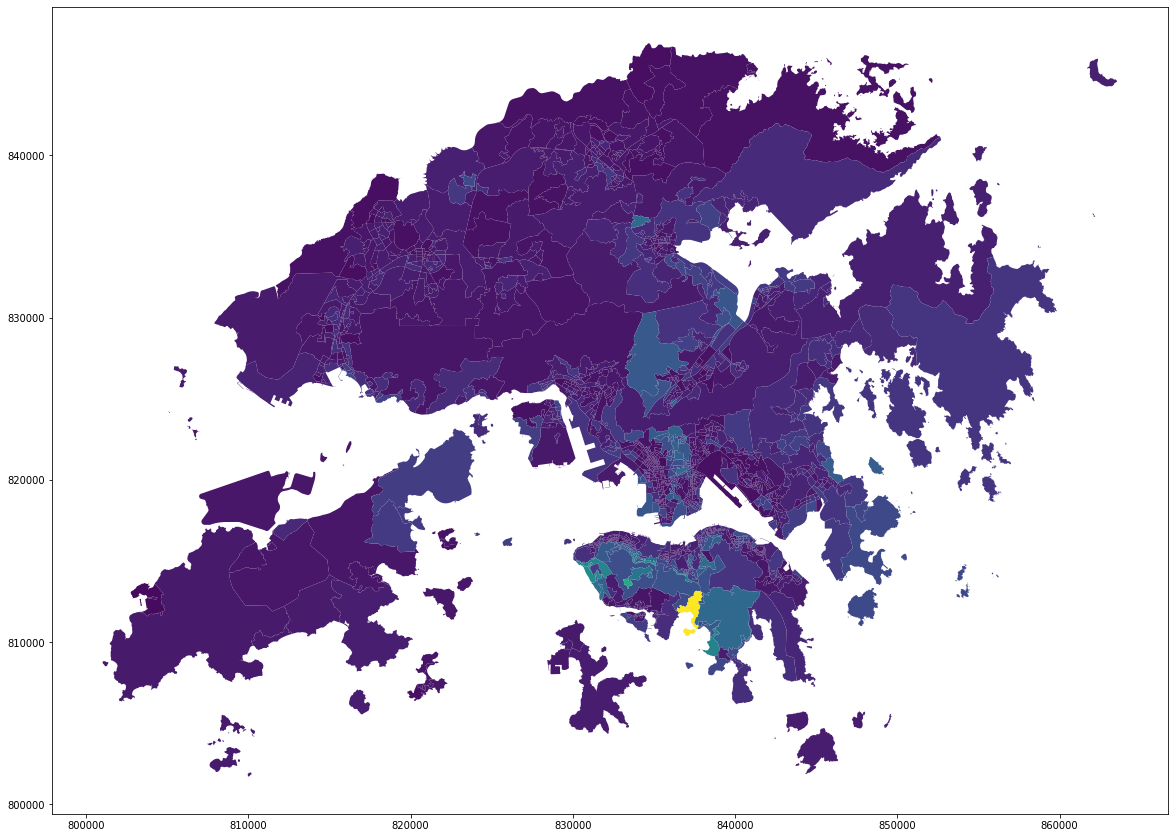

In [47]:
census.plot(column = "MA_HH", figsize = (20,20))
# plt.savefig("/Users/lamderek/Documents/Sudo/Study/University Study/Year 4/RECO4001 Dissertation/02_Analysis/01_resources/output_figures/MM_AH_origina,")


/Users/lamderek/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


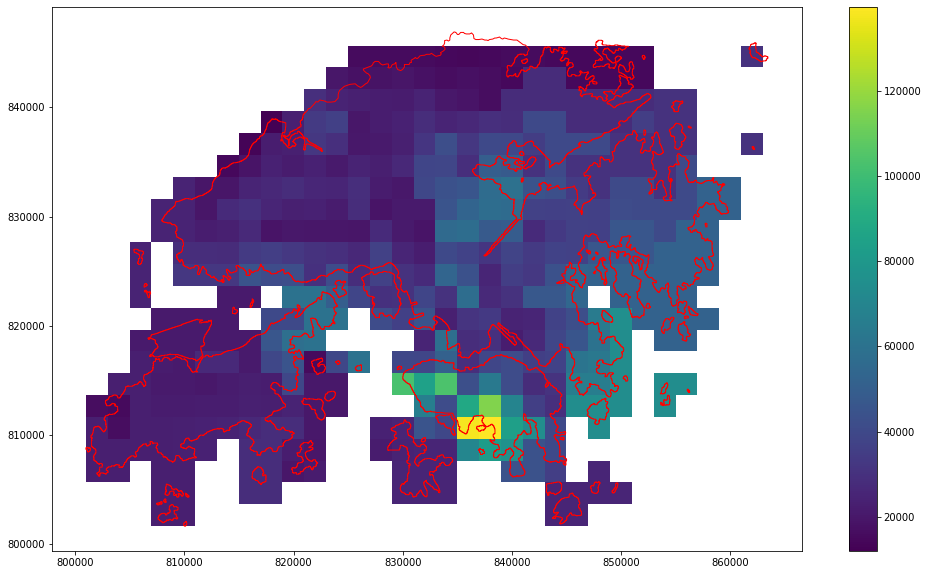

In [48]:
# ax = grid.plot(color= "white", edgecolor='black'
ax = temp_trial.plot(column = "MA_HH", legend = True, figsize = (17,10))
hongkong2.plot(facecolor="none", edgecolor = "red", ax = ax)
# plt.savefig("/Users/lamderek/Documents/Sudo/Study/University Study/Year 4/RECO4001 Dissertation/02_Analysis/01_resources/output_figures/MM_AH")